## NLP

In [ ]:
### Tihis NLP section is totally not mine and it has been done by a f

In [1]:
import os
from os.path import exists, join, expanduser
import tensorflow as tf
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN
import cv2
import torch
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import model_from_json
import sys
project_name = "pytorch-dc-tts"
sys.path.append(project_name)
import warnings
warnings.filterwarnings("ignore")  # ignore warnings in this notebook
import torch
from tqdm import *
import IPython
from IPython.display import Audio
from hparams import HParams as hp
from audio import save_to_wav
from models import Text2Mel, SSRN
from datasets.lj_speech import vocab, idx2char, get_test_data
from playsound import playsound
import matplotlib.pyplot as plt

In [2]:
torch.set_grad_enabled(False)
text2mel = Text2Mel(vocab)
text2mel.load_state_dict(torch.load("step-300K.pth").state_dict())
text2mel = text2mel.eval()
ssrn = SSRN()
ssrn.load_state_dict(torch.load("step-100K.pth").state_dict())
ssrn = ssrn.eval()

In [3]:
# synthetize by one by one because there is a batch processing bug!
def text_speech(SENTENCES):
    for i in range(len(SENTENCES)):
        sentence = SENTENCES[i]
        normalized_sentence = "".join([c if c.lower() in vocab else '' for c in sentence])
        print(normalized_sentence)
        
        sentences = [normalized_sentence]
        max_N = len(normalized_sentence)
        L = torch.from_numpy(get_test_data(sentences, max_N))
        zeros = torch.from_numpy(np.zeros((1, hp.n_mels, 1), np.float32))
        Y = zeros
        A = None

        for t in range(hp.max_T):
          _, Y_t, A = text2mel(L, Y, monotonic_attention=True)
          Y = torch.cat((zeros, Y_t), -1)
          _, attention = torch.max(A[0, :, -1], 0)
          attention = attention.item()
          if L[0, attention] == vocab.index('E'):  # EOS
              break

        _, Z = ssrn(Y)
        
        Z = Z.cpu().detach().numpy()
        save_to_wav(Z[0, :, :].T, SENTENCES[0]+".wav")
        #IPython.display.display(Audio('%d.wav' % (i + 1), rate=hp.sr))
        #playsound('%d.wav' % (i + 1),True)
  

# CV

In [4]:
def extract_face(filename, required_size=(224, 224)):
    
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

In [5]:
vgg = VGGFace(model='resnet50')
vgg.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_8[0][0]']           
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 55, 55, 256)  0           ['add_2[0][0]']                  
          

 add_5 (Add)                    (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_18[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_27[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_28 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_37[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_46 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_46[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_47[0][0]']          
          

In [6]:
vgg_org = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [7]:
vgg_org.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_57[0][0]']          
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_18 (Add)                   (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 55, 55, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 28, 28, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_67[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_76 (Activation)     (None, 14, 14, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_76[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_77 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_86[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_95 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_95[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_96 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_96[0][0]']          
          

In [8]:
##Freezing

flat1 = Flatten()(vgg_org.layers[-1].output)

vgg_flat = Model(vgg_org.input, flat1)
vgg_flat.trainable = False

for layer in vgg_org.layers:
    layer.trainable = False

vgg_flat.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_57[0][0]']          
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_18 (Add)                   (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 55, 55, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 28, 28, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_67[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_76 (Activation)     (None, 14, 14, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_76[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_77 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_86[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_95 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_95[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_96 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_96[0][0]']          
          

In [10]:
output = Dense(5, activation='softmax')(flat1)
my_vgg = Model(inputs=vgg_flat.inputs, outputs=output)

In [11]:
my_vgg.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_57[0][0]']          
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_18 (Add)                   (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 55, 55, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 28, 28, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_67[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_76 (Activation)     (None, 14, 14, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_76[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_77 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_86[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_95 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_95[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_96 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_96[0][0]']          
          

In [12]:
train = []

for img in os.listdir("images\\training"):
    print(img)
    pixels = extract_face("images\\training\\"+img)
    samples = np.asarray(pixels, 'float32')
    samples = preprocess_input(samples, version=2)
    train.append(samples)

mads_1.jpg
1/1 [==============================] - 0s 333ms/step
mads_10.jpg
1/1 [==============================] - 0s 142ms/step
mads_11.jpg
1/1 [==============================] - 0s 312ms/step
mads_12.jpg
1/1 [==============================] - 0s 363ms/step
mads_13.jpg
1/1 [==============================] - 0s 333ms/step
mads_14.jpg
1/1 [==============================] - 0s 368ms/step
mads_15.jpg
1/1 [==============================] - 0s 331ms/step
mads_16.jpg
1/1 [==============================] - 0s 318ms/step
mads_17.jpg
1/1 [==============================] - 0s 144ms/step
mads_18.jpg
1/1 [==============================] - 0s 368ms/step
mads_19.jpg
1/1 [==============================] - 0s 132ms/step
mads_2.jpg
1/1 [==============================] - 0s 141ms/step
mads_20.jpg
1/1 [==============================] - 0s 335ms/step
mads_3.jpg
1/1 [==============================] - 0s 339ms/step
mads_4.jpg
1/1 [==============================] - 0s 366ms/step
mads_5.jpg
1/1 [=============

1/1 [==============================] - 0s 141ms/step
messi_13.jpg
2/2 [==============================] - 0s 16ms/step
messi_14.jpg
1/1 [==============================] - 0s 138ms/step
messi_15.jpg
1/1 [==============================] - 0s 137ms/step
messi_16.jpg
1/1 [==============================] - 0s 130ms/step
messi_17.jpg
1/1 [==============================] - 0s 384ms/step
messi_18.jpg
1/1 [==============================] - 0s 131ms/step
messi_19.jpg
1/1 [==============================] - 0s 390ms/step
messi_2.jpg
1/1 [==============================] - 0s 141ms/step
messi_20.jpg
1/1 [==============================] - 0s 145ms/step
messi_3.jpg
1/1 [==============================] - 0s 142ms/step
messi_4.jpg
1/1 [==============================] - 0s 135ms/step
messi_5.jpg
1/1 [==============================] - 0s 141ms/step
messi_6.jpg
1/1 [==============================] - 0s 147ms/step
messi_7.jpg
1/1 [==============================] - 0s 136ms/step
messi_8.jpg
1/1 [=============

1/1 [==============================] - 0s 333ms/step
omar_18.jpg
1/1 [==============================] - 0s 133ms/step
omar_19.jpg
1/1 [==============================] - 0s 339ms/step
omar_2.jpg
1/1 [==============================] - 0s 132ms/step
omar_20.jpg
1/1 [==============================] - 0s 140ms/step
omar_3.jpg
1/1 [==============================] - 0s 136ms/step
omar_4.jpg
1/1 [==============================] - 0s 137ms/step
omar_5.jpg
1/1 [==============================] - 0s 350ms/step
omar_6.jpg
1/1 [==============================] - 0s 138ms/step
omar_7.jpg
1/1 [==============================] - 0s 142ms/step
omar_8.jpg
1/1 [==============================] - 0s 142ms/step
omar_9.jpg
1/1 [==============================] - 0s 133ms/step
salah_1.jpg
1/1 [==============================] - 0s 134ms/step
salah_10.jpg
1/1 [==============================] - 0s 144ms/step
salah_11.jpg
1/1 [==============================] - 0s 136ms/step
salah_12.jpg
1/1 [=========================

1/1 [==============================] - 0s 134ms/step
salah_4.jpg
1/1 [==============================] - 0s 134ms/step
salah_5.jpg
1/1 [==============================] - 0s 131ms/step
salah_6.jpg
1/1 [==============================] - 0s 133ms/step
salah_7.jpg
1/1 [==============================] - 0s 130ms/step
salah_8.jpg
1/1 [==============================] - 0s 132ms/step
salah_9.jpg
1/1 [==============================] - 0s 134ms/step
unknown_1.jpg
1/1 [==============================] - 0s 165ms/step
unknown_10.jpg
1/1 [==============================] - 0s 140ms/step
unknown_11.jpg
1/1 [==============================] - 0s 145ms/step
unknown_12.jpg
1/1 [==============================] - 0s 134ms/step
unknown_13.jpg
1/1 [==============================] - 0s 133ms/step
unknown_14.jpg
1/1 [==============================] - 0s 144ms/step
unknown_15.jpg
1/1 [==============================] - 0s 357ms/step
unknown_16.jpg
1/1 [==============================] - 0s 140ms/step
unknown_17.jpg

1/1 [==============================] - 0s 144ms/step


In [13]:
x_train = np.asarray(train)

In [14]:
x_train.shape

(100, 224, 224, 3)

In [15]:
train_labels = np.asarray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                           2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                           3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
                           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype="float32")

In [16]:
y_train = tf.keras.utils.to_categorical(train_labels)

In [17]:
labels_names = {0: "Mads Mikkelsen", 1:"Messi", 2:"Omar", 3:"Mohamed Salah",  4:"Unknown"}

In [19]:
val = []

for img in os.listdir("images\\validation"):
    print(img)
    pixels = extract_face("images\\validation\\"+img)
    samples = np.asarray(pixels, 'float32')
    samples = preprocess_input(samples, version=2)
    val.append(samples)

mads_1.jpg
1/1 [==============================] - 0s 140ms/step
mads_10.jpg
1/1 [==============================] - 0s 135ms/step
mads_2.jpg
1/1 [==============================] - 0s 141ms/step
mads_3.jpg
1/1 [==============================] - 0s 131ms/step
mads_4.jpg
1/1 [==============================] - 0s 136ms/step
mads_5.jpg
1/1 [==============================] - 0s 144ms/step
mads_6.jpg
1/1 [==============================] - 0s 142ms/step
mads_7.jpg
1/1 [==============================] - 0s 132ms/step
mads_8.jpg
1/1 [==============================] - 0s 130ms/step
mads_9.jpg
1/1 [==============================] - 0s 136ms/step
messi_1.jpg
1/1 [==============================] - 0s 126ms/step
messi_10.jpg
1/1 [==============================] - 0s 137ms/step
messi_2.jpg
1/1 [==============================] - 0s 131ms/step
messi_3.jpg
1/1 [==============================] - 0s 132ms/step
messi_4.jpg
1/1 [==============================] - 0s 137ms/step
messi_5.jpg
1/1 [================

1/1 [==============================] - 0s 141ms/step
omar_5.jpg
1/1 [==============================] - 0s 371ms/step
omar_6.jpg
1/1 [==============================] - 0s 135ms/step
omar_7.jpg
1/1 [==============================] - 0s 139ms/step
omar_8.jpg
1/1 [==============================] - 0s 135ms/step
omar_9.jpg
1/1 [==============================] - 0s 144ms/step
salah_1.jpg
1/1 [==============================] - 0s 138ms/step
salah_10.jpg
1/1 [==============================] - 0s 139ms/step
salah_2.jpg
1/1 [==============================] - 0s 139ms/step
salah_3.jpg
1/1 [==============================] - 0s 135ms/step
salah_4.jpeg
1/1 [==============================] - 0s 132ms/step
salah_5.jpg
1/1 [==============================] - 0s 138ms/step
salah_6.jpg
1/1 [==============================] - 0s 144ms/step
salah_7.jpg
1/1 [==============================] - 0s 130ms/step
salah_8.jpg
1/1 [==============================] - 0s 134ms/step
salah_9.jpg
1/1 [=======================

1/1 [==============================] - 0s 132ms/step
unknown_9.jpg
1/1 [==============================] - 0s 137ms/step


In [20]:
x_val = np.asarray(val)

In [21]:
x_val.shape

(50, 224, 224, 3)

In [22]:
val_labels = np.asarray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                         3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
                         4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype="float32")

In [23]:
y_val = tf.keras.utils.to_categorical(val_labels)

In [24]:
my_vgg.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [25]:
history = my_vgg.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
4/4 [==============================] - 17s 3s/step - loss: 2.4049 - accuracy: 0.3600 - val_loss: 0.8711 - val_accuracy: 0.7200
Epoch 2/20
4/4 [==============================] - 4s 1s/step - loss: 0.3738 - accuracy: 0.8600 - val_loss: 0.3499 - val_accuracy: 0.8800
Epoch 3/20
4/4 [==============================] - 4s 1s/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.2368 - val_accuracy: 0.9200
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 0.9200
Epoch 5/20
4/4 [==============================] - 4s 1s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9400
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1919 - val_accuracy: 0.9400
Epoch 7/20
4/4 [==============================] - 4s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9400
Epoch 8/20
4/4 [========================

In [ ]:
my_vgg.save('my_vggface2_pablo')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('my_vggface2')

In [ ]:
model.summary()

In [26]:
_, accuracy = my_vgg.evaluate(x_val, y_val)

2/2 [==============================] - 1s 536ms/step - loss: 0.1892 - accuracy: 0.9600


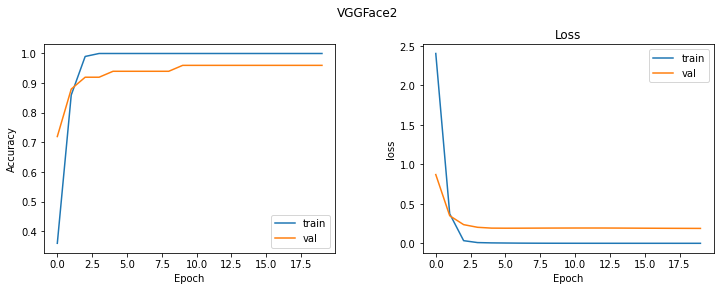

In [27]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
t = f.suptitle('VGGFace2', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='lower right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [28]:
mads_sound = text_speech(["Mads Mikkelsen"])
messi_sound = text_speech(["Messi"])
omar_sound = text_speech(["Omar"])
mo_salah_sound = text_speech(["Mohamed Salah"])
un_sound = text_speech(["Unknown"])
here = text_speech(["is here"])

Mads Mikkelsen
Messi
Omar
Mohamed Salah
Unknown
is here


In [29]:
cap = cv2.VideoCapture(0)
detector = MTCNN()

In [30]:
last_detected = "dummy"
cur_name = 'None'
while True:
    success, img = cap.read()
    results = detector.detect_faces(img)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize((224, 224))
        face_array = np.asarray(image)
        pixels = face_array.astype('float32')
        samples = expand_dims(pixels, axis=0)
        samples = preprocess_input(samples, version=2)
        yhat = my_vgg.predict(samples)
        decode_idx = np.argmax(yhat)
        if yhat[0][decode_idx] >= 0.7:
            decode_name = labels_names[decode_idx]
        else:
            decode_name = labels_names[4]
            
         
        cur_name = decode_name
        #name = decode_name.upper()
        print(decode_name)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.rectangle(img, (x1, y2-25), (x2, y2), (0,255,0), cv2.FILLED)
        cv2.putText(img, decode_name+", "+str(round(yhat[0][decode_idx], ndigits=2)), (x1+6, y2-6), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 1)
                
        cv2.imshow("webcam", img)

        cv2.waitKey(1)
        
        if cur_name != last_detected and cur_name != "Unknown":
            playsound(cur_name+".wav")
            playsound("is here.wav")
        
        elif cur_name != last_detected and cur_name == "Unknown":
            playsound(cur_name+".wav")
            
        last_detected = cur_name

1/1 [==============================] - 3s 3s/step
Omar
1/1 [==============================] - 0s 22ms/step
Omar
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 31ms/step
Omar
1/1 [==============================] - 0s 12ms/step
Omar
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
Omar
1/1 [==============================] - 0s 38ms/step
Omar
1/1 [==============================] - 0s 16ms/step
Mads Mikkelsen
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 19ms/step
Omar
1/1 [==============================] - 0s 32ms/step
Omar
1/1 [==============================] - 0s 16ms/step
Omar
1/1 [==============================] - 0s 15ms/step
Omar
1/1 [==============================] - 0s 22ms/step
Omar
1/1 [==============================] - 0s 20ms/step
Omar
1/1 [==============================] - 0s 29ms/step
Omar
1/1 [==============================] - 0s 34ms/step
Omar
1/1 [==============================] - 0s 24ms/step
Omar
1/1 [==============================] - 0s 18ms/step
Omar
1/1 [==============================] - 0s 24ms/step
Omar
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 33ms/step
Omar
1/1 [================

1/1 [==============================] - 0s 28ms/step
Omar
1/1 [==============================] - 0s 34ms/step
Omar
1/1 [==============================] - 0s 17ms/step
Omar
1/1 [==============================] - 0s 22ms/step
Omar
1/1 [==============================] - 0s 36ms/step
Omar
1/1 [==============================] - 0s 29ms/step
Omar
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 30ms/step
Omar
1/1 [==============================] - 0s 29ms/step
Omar
1/1 [==============================] - 0s 19ms/step
Omar
1/1 [==============================] - 0s 33ms/step
Omar
1/1 [==============================] - 0s 18ms/step
Omar
1/1 [==============================] - 0s 36ms/step
Omar
1/1 [==============================] - 0s 25ms/step
Omar
1/1 [==============================] - 0s 14ms/step
Omar
1/1 [==============================] - 0s 21ms/step
Omar
1/1 [==============================] - 0s 21ms/step
Omar
1/1 [==========================

1/1 [==============================] - 0s 22ms/step
Unknown
1/1 [==============================] - 0s 25ms/step
Unknown
1/1 [==============================] - 0s 21ms/step
Omar
1/1 [==============================] - 0s 29ms/step
Unknown
1/1 [==============================] - 0s 27ms/step
Unknown
1/1 [==============================] - 0s 25ms/step
Unknown
1/1 [==============================] - 0s 26ms/step
Unknown
1/1 [==============================] - 0s 19ms/step
Unknown
1/1 [==============================] - 0s 17ms/step
Unknown
1/1 [==============================] - 0s 28ms/step
Omar
1/1 [==============================] - 0s 21ms/step
Unknown
1/1 [==============================] - 0s 24ms/step
Unknown
1/1 [==============================] - 0s 16ms/step
Omar
1/1 [==============================] - 0s 24ms/step
Unknown
1/1 [==============================] - 0s 30ms/step
Omar
1/1 [==============================] - 0s 18ms/step
Unknown
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 27ms/step
Omar
1/1 [==============================] - 0s 27ms/step
Unknown
1/1 [==============================] - 0s 17ms/step
Omar
1/1 [==============================] - 0s 23ms/step
Omar
1/1 [==============================] - 0s 26ms/step


KeyboardInterrupt: 